# Setup - This notebook runs on google colab

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from PIL import Image
import requests
from io import BytesIO
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import re

import warnings
warnings.simplefilter("ignore")

# Getting data

## Download the files from google drive to colab cloud

In [2]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data/pickle/')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'11mLhhzlzjCeArB4oE0F957IgaxHdG5et' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: cs_matrix_collaborative.pkl, id: 1UdyxoRIlAO4XfkA8XXeq-QXPMirgJdac
downloading to /root/data/pickle/cs_matrix_collaborative.pkl
title: cs_matrix_content.pkl, id: 1TJ8RQtr4hwXuIPSt-nQhzhibkMw0v_qg
downloading to /root/data/pickle/cs_matrix_content.pkl
title: mat.pkl, id: 1FkD0eLhFfVJahz_xVDKCYa5UNO0eTsv4
downloading to /root/data/pickle/mat.pkl
title: reviews_processed.pkl, id: 1INZrQArrHolzKwv4TYw6Hsfvj-5c9BPr
downloading to /root/data/pickle/reviews_processed.pkl
title: products_processed.pkl, id: 1kQqYMQoM4ouh6HAY5OwSMLo5M4F6tw7q
downloading to /root/data/pickle/products_processed.pkl
title: id_link.pkl, id: 1fDN_D2b7NA6-rk1dLH5zlwaqfo0OS27d
downloading to /root/data/pickle/id_link.pkl
title: all_review_data_list.pkl, id: 1xoD2dCAghDOVq6z97UAhpl_lC_-aPqph
downloading to /root/data/pickle/all_review_data_list.pkl
title: all_product_data_list.pkl, id: 1g_fXH7Dx348OL06Yc3z0j_VbVHdcRzqz
downloading to /root/data/pickle/all_product_data_list.pkl


## Reading from colab into the notebook

In [ ]:
# retrieve data from pickle files
pkl_product_file = '/root/data/pickle/products_processed.pkl'
pkl_review_file = '/root/data/pickle/reviews_processed.pkl'

# product_data_list
with open(pkl_product_file, 'rb') as f:
  all_product_data_list = pickle.load(f)
  
# product_review_list
with open(pkl_review_file, 'rb') as f:
  all_review_data_list = pickle.load(f)

# Data preprocessing

## Reset here

In [0]:
# Code for resetting data
review_data = all_review_data_list.copy()

## Drop redundant columns

In [0]:
# dropping reduntant columns
review_data = review_data.drop(columns= ['birthday','height','standardSize','weight', 'reviewId'])

In [6]:
review_data.head()

,item_id,averageRating,countRatings,currentCount,user_id,age,bodyType,bustSize,numReviewsByUser,heightInches,joined,nickName,usStandardSize,weightPounds,caption,content,fit,rating,uploadedAt,product_img_link
0,FLN35,8.0,10,10,16844044,24,Hourglass,32DDD/E,3,65,None,None,4,None,Super cute dress but wide neck can gape,This fit great in the waist but not so much an...,None,8,2019-11-15T18:50:02.000+00:00,https://pc-ap.rtrcdn.com/productimages/nomodel...
1,FLN35,8.0,10,10,17725300,29,Petite,34D,44,61,None,Lucie,4,125,RTR TEAM REVIEW,This dress was so good I had to take the bathr...,None,10,2019-11-12T13:12:08.000+00:00,https://pc-ap.rtrcdn.com/productimages/nomodel...
2,FLN35,8.0,10,10,19431324,21,Hourglass,34DDD/E,4,66,2019-10-02T18:26:21.000+00:00,Courtney,6,155,Soooooo cute,"Loved it, definitely mini length. It was tight...",None,10,2019-11-12T00:59:48.000+00:00,https://pc-ap.rtrcdn.com/productimages/nomodel...
3,FLN35,8.0,10,10,10992590,30,Hourglass,32DDD/E,9,67,None,Alyssa,6,150,"Cute dress, too short.","The fit of this dress was great, but the lengt...",None,6,2019-10-28T01:31:08.000+00:00,https://pc-ap.rtrcdn.com/productimages/nomodel...
4,FLN35,8.0,10,10,12064814,40,Hourglass,36B,10,65,2016-07-27T05:06:28.000+00:00,Mayra,10,164,Sexy but classy,I really felt sexy in this dress but with a to...,None,8,2019-10-22T06:38:46.000+00:00,https://pc-ap.rtrcdn.com/productimages/nomodel...


## Fixing variable types

### Numeric data

In [0]:
review_data = review_data.astype({'numReviewsByUser': 'int',\
                                  'rating': 'int', \
                                  'age': 'float', \
                                  'heightInches': 'float',\
                                  'weightPounds': 'float'})

### US Standard size

In [0]:
numeric_sizes = ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22']
                 
size_numeric = review_data.loc[review_data['usStandardSize'].isin(numeric_sizes), :]
size_24p = review_data.loc[review_data['usStandardSize'] == '24+', :]
size_others = review_data.loc[ ((review_data['usStandardSize'].isin(numeric_sizes)) | (review_data['usStandardSize'] == '24+')) == False, :]

size_others['usStandardSize'] = np.nan
size_24p['usStandardSize'] = 24
size_numeric = size_numeric.astype({'usStandardSize': 'float'})
review_data = pd.concat([size_numeric, size_24p, size_others])

### Date Time 

In [0]:
review_data['joined'] = pd.to_datetime(review_data['joined'])
review_data['uploadedAt'] = pd.to_datetime(review_data['uploadedAt'])

### Bust data

In [0]:
# fixing bust_data column 
bust_data = review_data['bustSize'].str.extract('([^a-zA-Z]+)([a-zA-Z]+)', expand=True)
bust_data.columns = ['bust_size', 'bust_type']
review_data = review_data.join(bust_data)
review_data = review_data.astype({'bust_size': 'float'})
review_data = review_data.drop(columns=['bustSize'])

## Missing value treatment

In [11]:
pd.set_option("display.max_rows",None)
print(review_data.isna().sum())
pd.set_option("display.max_rows",60)

item_id                  0
averageRating            0
countRatings             0
currentCount             0
user_id                  0
age                  12259
bodyType             51378
numReviewsByUser         0
heightInches         33927
joined              228698
nickName             77495
usStandardSize        6637
weightPounds         91751
caption                 17
content                  0
fit                 209138
rating                   0
uploadedAt               0
product_img_link       386
bust_size            66278
bust_type            66278
dtype: int64


### Numerical data

In [0]:
#Imptuting data with mean 
review_data.loc[review_data['age'].isna(), 'age'] = np.mean(review_data['age'])
review_data.loc[review_data['heightInches'].isna(), 'heightInches'] = np.mean(review_data['heightInches'])
review_data.loc[review_data['weightPounds'].isna(), 'weightPounds'] = np.mean(review_data['weightPounds'])

### Categorical data

In [0]:
# Imputing data with mode
review_data.loc[review_data['bodyType'].isna(), 'bodyType'] = review_data['bodyType'].value_counts().index[0]
review_data.loc[review_data['bust_size'].isna(), 'bust_size'] = review_data['bust_size'].value_counts().index[0]
review_data.loc[review_data['bust_type'].isna(), 'bust_type'] = review_data['bust_type'].value_counts().index[0]
review_data.loc[review_data['usStandardSize'].isna(), 'usStandardSize'] = review_data['usStandardSize'].value_counts().index[0]

### Removing columns with more than 50% missing values

In [0]:
review_data = review_data.drop(columns = 'joined')

### Final summary for missing values

In [15]:
pd.set_option("display.max_rows",None)
print(review_data.isna().sum())
pd.set_option("display.max_rows",60)

item_id                  0
averageRating            0
countRatings             0
currentCount             0
user_id                  0
age                      0
bodyType                 0
numReviewsByUser         0
heightInches             0
nickName             77495
usStandardSize           0
weightPounds             0
caption                 17
content                  0
fit                 209138
rating                   0
uploadedAt               0
product_img_link       386
bust_size                0
bust_type                0
dtype: int64


## Dummy variables

### bodyType

In [0]:
bodyType_dummies = pd.get_dummies(review_data['bodyType'], prefix='bodyType')
review_data = review_data.join(bodyType_dummies)
review_data = review_data.drop(columns = ['bodyType'])

### fit

In [0]:
fit_dummies = pd.get_dummies(review_data['fit'], prefix='fit')
review_data = review_data.join(fit_dummies)
review_data = review_data.drop(columns = ['fit'])

### bust_type

In [0]:
bust_type_dummies = pd.get_dummies(review_data['bust_type'], prefix='bust_type')
review_data = review_data.join(bust_type_dummies)
review_data = review_data.drop(columns = ['bust_type'])

# Data Exploration

In [19]:
# Columns and data types
pd.set_option("display.max_rows",None)
print(review_data.dtypes)
pd.set_option("display.max_rows",60)

item_id                                    object
averageRating                             float64
countRatings                                int64
currentCount                                int64
user_id                                     int64
age                                       float64
numReviewsByUser                            int64
heightInches                              float64
nickName                                   object
usStandardSize                            float64
weightPounds                              float64
caption                                    object
content                                    object
rating                                      int64
uploadedAt                    datetime64[ns, UTC]
product_img_link                           object
bust_size                                 float64
bodyType_Apple                              uint8
bodyType_Athletic                           uint8
bodyType_Full Bust                          uint8


In [0]:
# Rows and columns
print('The dataset has ', review_data.shape[0], 'reviews and ' , review_data.shape[1], 'columns')

The dataset has  375480 products and  39 columns


In [0]:
# Unique users
print('Total distinct users:', review_data['user_id'].nunique())

Total distinct users: 137879


In [0]:
# Unique products with reviews
print('Total distinct products with reviews:', review_data['item_id'].nunique())

Total distinct products with reviews: 15611


In [0]:
# Duration of uploadedAt
min_upload_date = review_data['uploadedAt'].min().date()
max_upload_date = review_data['uploadedAt'].max().date()

print('Review data from', min_upload_date, 'to', max_upload_date)

Review data from 2013-09-19 to 2019-11-23


In [2]:
# Year wise
year_data = review_data.groupby(review_data['uploadedAt'].dt.year).size()
year_data.plot(kind = 'bar')
plt.title('uploadedAT')
plt.show()

NameError: name 'review_data' is not defined

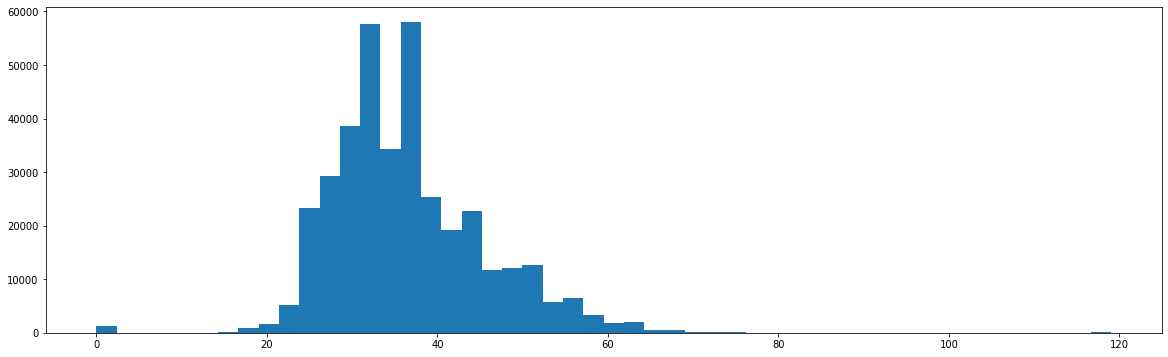

In [0]:
# age
figure(num=None, figsize=(20, 6))
plt.hist(review_data['age'], bins = 50)
plt.show()

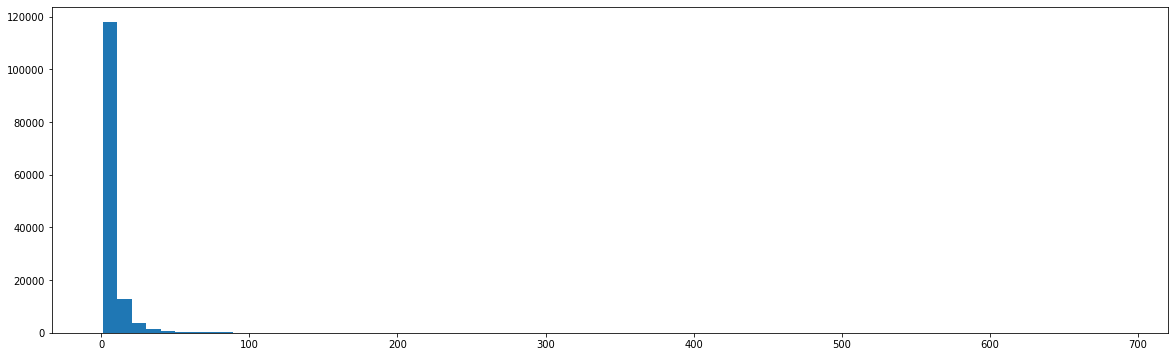

In [0]:
# numReviewsByUser
dedup = review_data.drop_duplicates('user_id')
figure(num=None, figsize=(20, 6))
plt.hist(dedup.loc[:, 'numReviewsByUser'], bins = 70)
plt.show()

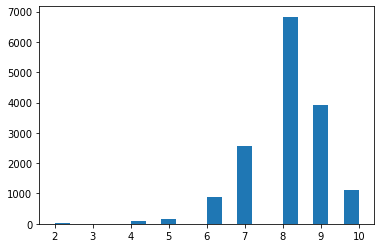

In [0]:
# averageRating
dedup = review_data.drop_duplicates('item_id')
plt.hist(dedup['averageRating'], bins = 20)
plt.show()

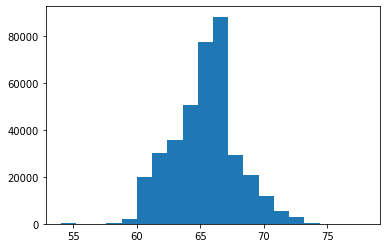

In [0]:
# heightInches
plt.hist(review_data['heightInches'], bins = 20)
plt.show()

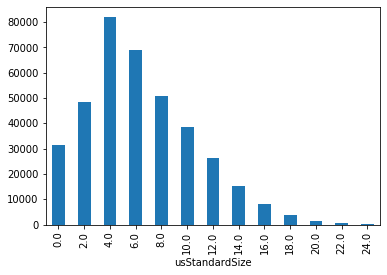

In [0]:
# usStandardSize
usStandardSize_data = review_data.groupby('usStandardSize').size()
usStandardSize_data.plot(kind = 'bar')
plt.show()

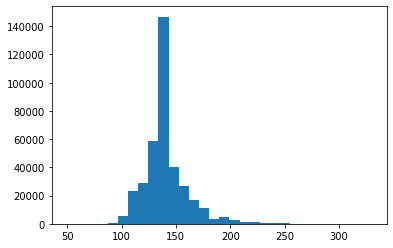

In [0]:
# weightPounds
plt.hist(review_data['weightPounds'], bins = 30)
plt.show()

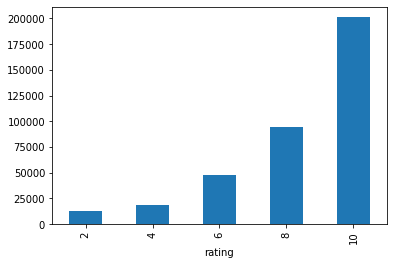

In [0]:
# rating
rating_data = review_data.groupby('rating').size()
rating_data.plot(kind = 'bar')
plt.show()

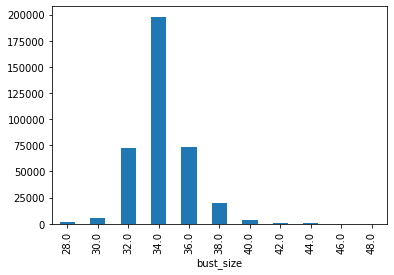

In [0]:
# bust_size
rating_data = review_data.groupby('bust_size').size()
rating_data.plot(kind = 'bar')
plt.show()

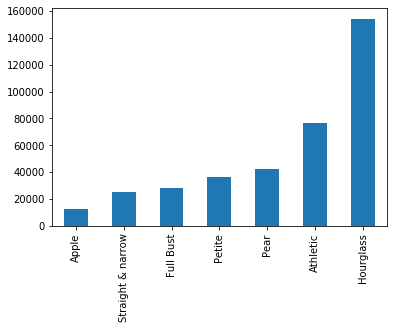

In [0]:
# bodyType
bodyType = [x for x in review_data.columns if x.startswith('bodyType')]
bodyType_data = review_data[bodyType].sum().sort_values()
bodyType_data.index = [x.replace('bodyType_', "") for x in bodyType_data.index]
bodyType_data.plot(kind = 'bar')
plt.show()

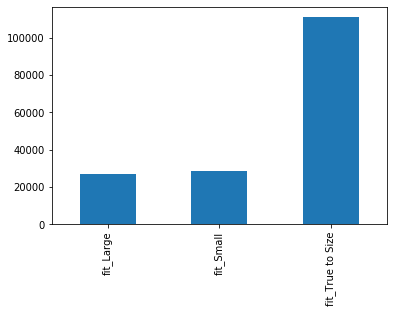

In [0]:
# bodyType
fit = [x for x in review_data.columns if x.startswith('fit')]
fit_data = review_data[fit].sum().sort_values()
fit_data.index = [x.replace('bodyType_', "") for x in fit_data.index]
fit_data.plot(kind = 'bar')
plt.show()

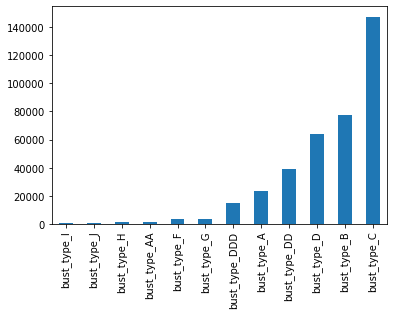

In [0]:
# bust_type
bust_type = [x for x in review_data.columns if x.startswith('bust_type')]
bust_type_data = review_data[bust_type].sum().sort_values()
bust_type_data.index = [x.replace('bodyType_', "") for x in bust_type_data.index]
bust_type_data.plot(kind = 'bar')
plt.show()

# Collaborative Filtering

In [21]:
list(review_data)

['item_id',
 'averageRating',
 'countRatings',
 'currentCount',
 'user_id',
 'age',
 'numReviewsByUser',
 'heightInches',
 'nickName',
 'usStandardSize',
 'weightPounds',
 'caption',
 'content',
 'rating',
 'uploadedAt',
 'product_img_link',
 'bust_size',
 'bodyType_Apple',
 'bodyType_Athletic',
 'bodyType_Full Bust',
 'bodyType_Hourglass',
 'bodyType_Pear',
 'bodyType_Petite',
 'bodyType_Straight & narrow',
 'fit_Large',
 'fit_Small',
 'fit_True to Size',
 'bust_type_A',
 'bust_type_AA',
 'bust_type_B',
 'bust_type_C',
 'bust_type_D',
 'bust_type_DD',
 'bust_type_DDD',
 'bust_type_F',
 'bust_type_G',
 'bust_type_H',
 'bust_type_I',
 'bust_type_J']

## Creating Sparse matrix of user vectors

### User-Item attributes

###### Get unique users and products

In [0]:
all_users = review_data['user_id'].value_counts()
filter_ = all_users > 5 # Filter users with at least these number of ratings
users = list(all_users[filter_].index)

all_products = review_data.loc[review_data['user_id'].isin(users), 'item_id'].value_counts()
products = list(all_products.index)

###### Create user and product mapping for sparse matrix

In [0]:
user_mapping = {}
for i, user in enumerate(users):
  user_mapping[user] = i

product_mapping = {}
for i, product in enumerate(products):
  product_mapping[product] = i

##### Remove users with less than given number of ratings count

In [0]:
data_coll = review_data.loc[review_data['user_id'].isin(users), :]

##### Calculate mean rating per user and product combination

In [0]:
user_item_rating = data_coll.groupby(['user_id', 'item_id']).agg({'rating': 'mean'}).reset_index()

### User-demog attributes

#### Dedup user rows

In [0]:
cols_to_keep = ['user_id', 
                'age', 
                'numReviewsByUser',
                'heightInches',
                'usStandardSize',
                'weightPounds',
                'bust_size',
                'bodyType_Apple',
                'bodyType_Athletic',
                'bodyType_Full Bust',
                'bodyType_Hourglass',
                'bodyType_Pear',
                'bodyType_Petite',
                'bodyType_Straight & narrow',
                'fit_Large',
                'fit_Small',
                'fit_True to Size',
                'bust_type_A',
                'bust_type_AA',
                'bust_type_B',
                'bust_type_C',
                'bust_type_D',
                'bust_type_DD',
                'bust_type_DDD',
                'bust_type_F',
                'bust_type_G',
                'bust_type_H',
                'bust_type_I',
                'bust_type_J']

review_data_nodup = review_data.drop_duplicates('user_id')
review_data_nodup = review_data_nodup[cols_to_keep]

##### Remove users with less than given number of ratings count

In [0]:
review_data_nodup = review_data_nodup.loc[review_data_nodup['user_id'].isin(users), :]

##### Melt

In [0]:
review_data_nodup_melt = review_data_nodup.melt(id_vars = ['user_id'])

#### Create demog mapping

In [0]:
uniq_demogs = ['age', 
               'numReviewsByUser',
               'heightInches',
               'usStandardSize',
               'weightPounds',
               'bust_size',
               'bodyType_Apple',
               'bodyType_Athletic',
               'bodyType_Full Bust',
               'bodyType_Hourglass',
               'bodyType_Pear',
               'bodyType_Petite',
               'bodyType_Straight & narrow',
               'fit_Large',
               'fit_Small',
               'fit_True to Size',
               'bust_type_A',
               'bust_type_AA',
               'bust_type_B', 
               'bust_type_C', 
               'bust_type_D',
               'bust_type_DD',
               'bust_type_DDD',
               'bust_type_F',
               'bust_type_G',
               'bust_type_H',
               'bust_type_I',
               'bust_type_J']
demog_mapping = {}
for i, demog in enumerate(uniq_demogs):
  demog_mapping[demog] = i + max(product_mapping.values())

### Join the mapping to variables

In [0]:
# user_item_rating
user_item_rating['user_mapping'] = user_item_rating['user_id'].map(user_mapping)
user_item_rating['product_mapping'] = user_item_rating['item_id'].map(product_mapping)

# review_data_nodup_melt 
review_data_nodup_melt['user_mapping'] = review_data_nodup_melt['user_id'].map(user_mapping)
review_data_nodup_melt['demog_mapping'] = review_data_nodup_melt['variable'].map(demog_mapping)

### Create Sparse matrix

In [0]:
# segregate product variables
user_item_rating['item_id'] = 'Product_' + user_item_rating['item_id']

In [0]:
# Rename columns for appending dataframes
colnames = ['user_id', 'variable', 'value', 'user_mapping', 'variable_mapping']
user_item_rating.columns = colnames
review_data_nodup_melt.columns = colnames

In [0]:
# Append dataframes
row_col_mapping_dense = pd.concat([user_item_rating, review_data_nodup_melt])

In [0]:
# Create Sparse matrix
mat = sparse.coo_matrix( ( row_col_mapping_dense["value"], (row_col_mapping_dense["user_mapping"], row_col_mapping_dense["variable_mapping"]) ) )

## Cosine Similarity

### Scaling

In [0]:
scaler = StandardScaler(with_mean = False)
scaler.fit(mat)
mat_std = scaler.transform(mat)

### Unit Vectors

In [0]:
normalizer = Normalizer(copy=False) 
mat_std_unit = normalizer.fit_transform(mat_std)

### Cosine Similarity matrix

In [0]:
# Calculate cosine similarity among products
cs = cosine_similarity(mat_std_unit)
cs_matrix = pd.DataFrame(cs)
cs_matrix.index = users
cs_matrix.columns = users
cs_matrix

,12247768,10979088,7840766,1060714,1752866,14851802,7950828,12735534,1420959,9552632,10589418,8868288,13649902,9081020,10358490,14136216,5724452,9048222,9778022,1069816,11189028,7633784,1638410,15675340,17897161,3326359,14158544,2522915,3533477,3168407,7583092,13235844,12406074,10796556,1529381,11201762,10336722,16429924,7000276,17794177,...,17162032,11162856,8807832,18630179,18243393,18865583,18362197,16386421,16255285,17530852,10351900,1009774,18259452,1722111,9256398,17595109,18239841,2021032,16547588,17763022,12120650,16945341,16423226,1040840,17172554,9877494,10598332,7414906,16903569,3401403,18821833,8134440,1327364,18820167,4388970,9131718,1725706,1865658,11991124,9725552
12247768,1.000000,0.026409,0.014369,0.020789,0.051383,0.005955,0.028322,0.009995,0.008442,0.012224,0.027451,0.022263,0.034865,0.018594,0.021232,0.027934,0.045417,0.009695,0.020458,0.033045,0.020947,0.019552,0.023779,0.029223,0.005640,0.011621,0.011144,0.025014,0.026630,0.025159,0.010788,0.008493,0.025396,0.012633,0.007395,0.025852,0.011668,0.006192,0.020050,0.023970,...,0.024396,0.023819,0.016294,0.020396,0.018962,0.023527,0.017786,0.021800,0.025291,0.027035,0.026061,0.016863,0.020344,0.018040,0.015428,0.011855,0.022342,0.020631,0.018244,0.019723,0.013257,0.016097,0.015909,0.015990,0.032804,0.015109,0.021484,0.012631,0.014745,0.015488,0.014813,0.016273,0.021848,0.015097,0.023239,0.013087,0.018709,0.022155,0.011147,0.012647
10979088,0.026409,1.000000,0.005254,0.021410,0.025631,0.015591,0.022717,0.004908,0.015540,0.005821,0.028191,0.007976,0.036048,0.020130,0.011608,0.005551,0.017927,0.004357,0.013512,0.022315,0.013655,0.024637,0.016349,0.010152,0.027934,0.027944,0.021709,0.006164,0.007320,0.007004,0.015690,0.010454,0.018712,0.005328,0.014596,0.035860,0.011342,0.010342,0.012544,0.013420,...,0.028525,0.027919,0.019266,0.024095,0.022107,0.027672,0.020862,0.025566,0.029835,0.031594,0.030432,0.019710,0.023768,0.021126,0.018115,0.013885,0.026120,0.024020,0.021441,0.023166,0.015450,0.018842,0.018544,0.018788,0.025696,0.017585,0.025205,0.014918,0.017262,0.018115,0.017372,0.019067,0.016751,0.017742,0.027257,0.015238,0.021757,0.025928,0.013047,0.014725
7840766,0.014369,0.005254,1.000000,0.024412,0.017932,0.021156,0.012581,0.003672,0.006436,0.028169,0.018390,0.010922,0.016140,0.011001,0.009223,0.006832,0.009801,0.024479,0.009544,0.006994,0.012487,0.003388,0.015243,0.005728,0.027233,0.008546,0.005692,0.026511,0.008045,0.005300,0.013153,0.007268,0.011628,0.011778,0.019395,0.007505,0.005784,0.007370,0.009949,0.009862,...,0.021985,0.021580,0.014839,0.018565,0.017004,0.021179,0.016026,0.036995,0.022965,0.024293,0.023471,0.015149,0.018272,0.016333,0.013989,0.010713,0.020121,0.018391,0.016515,0.017786,0.011965,0.014490,0.014305,0.050826,0.019780,0.013419,0.019399,0.011489,0.013193,0.013950,0.013423,0.014614,0.012941,0.013627,0.021063,0.011776,0.016745,0.032869,0.010033,0.011310
1060714,0.020789,0.021410,0.024412,1.000000,0.036506,0.013157,0.025619,0.011072,0.014669,0.005420,0.011723,0.012223,0.026851,0.010128,0.015649,0.019081,0.012338,0.012636,0.012704,0.005809,0.013969,0.020291,0.008034,0.013787,0.029178,0.022921,0.017084,0.005709,0.005529,0.006472,0.006591,0.005812,0.006022,0.011091,0.020772,0.017014,0.006601,0.009666,0.005264,0.004330,...,0.026020,0.031974,0.017519,0.064946,0.020480,0.025305,0.019055,0.023303,0.027009,0.029318,0.027908,0.018072,0.021602,0.019291,0.049557,0.012688,0.023947,0.022026,0.019691,0.021269,0.014188,0.017213,0.017166,0.017113,0.023627,0.016040,0.022988,0.013509,0.015719,0.016585,0.015855,0.017393,0.015274,0.016142,0.024969,0.013977,0.019978,0.023510,0.011902,0.013445
1752866,0.051383,0.025631,0.017932,0.036506,1.000000,0.004820,0.023226,0.008585,0.009813,0.015115,0.016020,0.019652,0.051980,0.022337,0.018963,0.025544,0.044807,0.004774,0.020621,0.010973,0.015792,0.026007,0.027634,0.013473,0.006680,0.020552,0.012087,0.017840,0.012705,0.007735,0.004240,0.007037,0.013746,0.010611,0.031472,0.019302,0.010921,0.007591,0.008712,0.021722,...,0.063299,0

In [0]:
# # Save to pickle
# with open('cs_matrix_collaborative.pkl', 'wb') as f:
#     pickle.dump(cs_matrix, f)

# # save to drive
# link = 'https://drive.google.com/open?id=11mLhhzlzjCeArB4oE0F957IgaxHdG5et'
# _, id = link.split("=")

# # get the folder id where you want to save your file
# file = drive.CreateFile({'parents':[{u'id': id}]})
# file.SetContentFile('cs_matrix_collaborative.pkl')
# file.Upload() 

In [0]:
# # Load from pickle
# cs_matrix_file = '/root/data/pickle/cs_matrix_collaborative.pkl'
# with open(cs_matrix_file, 'rb') as f:
#   cs_matrix = pickle.load(f)

## Making recommendations

### Functions

#### Function for getting similar attributes and activities

In [0]:
def get_similarities(user1, user2):
  # Similar ratings
  user1_rating_df = user_item_rating.loc[(user_item_rating['user_id'] == user1) &
                      (user_item_rating['value'] != 0), ['variable', 'value']]

  user2_rating_df = user_item_rating.loc[(user_item_rating['user_id'] == user2) &
                      (user_item_rating['value'] != 0), ['variable', 'value']]

  similarities_rating_df = user1_rating_df.merge(user2_rating_df, 
                                                left_on = 'variable', 
                                                right_on = 'variable', 
                                                how='inner', 
                                                suffixes=('_'+str(user1), '_'+str(user2)))

  # Similar demogs
  user1_demog_df = review_data_nodup_melt.loc[(review_data_nodup_melt['user_id'] == user1) &
                      (review_data_nodup_melt['value'] != 0), ['variable', 'value']]

  user2_demog_df = review_data_nodup_melt.loc[(review_data_nodup_melt['user_id'] == user2) &
                      (review_data_nodup_melt['value'] != 0), ['variable', 'value']]

  similarities_demog_df = user1_demog_df.merge(user2_demog_df, 
                                              left_on = 'variable', 
                                              right_on = 'variable', 
                                              how='inner', 
                                               suffixes=('_'+str(user1), '_'+str(user2)))

  # Append
  similarities_df = pd.concat([similarities_rating_df, similarities_demog_df])
  return similarities_df

#### Function for getting same products links

In [0]:
def same_products_links(similarities_df):
  similarities_df_products = similarities_df.loc[similarities_df['variable']\
                                      .apply(lambda x: x.startswith('Product')), :]\

  similarities_df_products['product'] = similarities_df_products['variable'].apply(lambda x: x.split('_')[1])
  similarities_df_products = similarities_df_products.join(all_product_data_list[['designer_name', 'displayName','product_img_link']], on='product')
  similarities_df_products.columns = ['variable', 'user1', 'user2', 'product', 'designer_name', 'displayName', 'product_img_link']

  i = 1
  for designer, display_name in zip(similarities_df_products['designer_name'], similarities_df_products['displayName']):
    product_link = create_url(designer, display_name)
    print('Same product', str(i), product_link)
    i+=1
  return similarities_df_products[['product', 'displayName', 'product_img_link']]

#### Function for getting recommendations based on unrated products

In [0]:
def get_recommendations_two_users(user1, user2):
  # Ratings
  user1_rating_df = user_item_rating.loc[(user_item_rating['user_id'] == user1) &
                      (user_item_rating['value'] != 0), ['variable', 'value']]

  user2_rating_df = user_item_rating.loc[(user_item_rating['user_id'] == user2) &
                      (user_item_rating['value'] != 0), ['variable', 'value']]
  # Join
  joined_rating_df = user2_rating_df.merge(user1_rating_df, 
                                                left_on = 'variable', 
                                                right_on = 'variable', 
                                                how='left', 
                                                suffixes=('_'+str(user2), '_'+str(user1)))
  # Unrated products by user1
  unrated_products_df = joined_rating_df.loc[joined_rating_df['value_' + str(user1)].isna(), :]
  # Sort by ratings
  unrated_products_df = unrated_products_df.sort_values(by='value_' + str(user2), ascending=False)
  # Filter products with at least rating = 8
  recommended_products = unrated_products_df.loc[unrated_products_df['value_' + str(user2)] >= 8, 'variable']
  # Recommend top 5 products
  recommended_products = recommended_products[:5]
  return recommended_products, unrated_products_df

#### Function for getting product link

In [0]:
def create_url(designer, display_name):
  link = 'https://www.renttherunway.com/shop/designers/' + \
          re.sub(r'[^a-zA-Z0-9_]', '', designer.replace(' ', '_')).lower() + \
          '/' + \
          re.sub(r'[^a-zA-Z0-9_]', '', display_name.replace(' ', '_')).lower()
  return link

#### Function for printing images

In [0]:
def print_images(df, text_to_write):
  if df.shape[0] > 5:
    df = df.iloc[:5,:]

  product_img_link = df['product_img_link'].values
  displayName = df['displayName'].values
  product = df['product'].values

  n = len(product_img_link)
  if n > 1:
    fig, axs = plt.subplots(1, n, figsize=(n*4, 5))
    i = 0
    for link, display_name, id_ in zip(product_img_link, displayName, product):
      if type(link) == str:
          response = requests.get(link)
          img = Image.open(BytesIO(response.content))
          axs[i].imshow(np.asarray(img))
          axs[i].set_title(text_to_write + str(i+1) + ': ' + id_ + '\n' + display_name)
          # axs[i].axis('off')

      else:
        link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs[i].imshow(np.asarray(img))
        axs[i].set_title(id_)
        # axs[i].axis('off')
      i+=1
    plt.show()

  else:
    fig, axs = plt.subplots(1, n, figsize=(n*4, 5))
    i = 0
    for link, display_name, id_ in zip(product_img_link, displayName, product):
      if type(link) == str:
          response = requests.get(link)
          img = Image.open(BytesIO(response.content))
          axs.imshow(np.asarray(img))
          axs.set_title(text_to_write + str(i+1) + ': ' + id_ + '\n' + display_name)
          # axs[i].axis('off')

      else:
        link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs.imshow(np.asarray(img))
        axs.set_title(id_)
        # axs[i].axis('off')
      i+=1
    plt.show()

### Recommend

#### Get some user IDs

In [0]:
cs_matrix.columns[50:100]

Int64Index([18286340,  8213438,  2077394,  1922833, 10467724, 16772914,
             1102156, 15277568,  3340225, 15143026, 16255079, 17601220,
             4613566,  1077975, 16611580, 12083148, 18025438,  3849381,
            11377866,  8642554, 17793799, 17465125,  1489559,  6212880,
            12495690,  8049456,  1717703,  8237044,  3528685, 17114947,
            16159103,  7730184, 12177980,  5619288,  3683619,  2566619,
             9642504, 15601638,  6655488, 18228939, 15255662, 12052494,
            15367084, 13253654, 15846621,  1233836, 12075038, 15403204,
            12550826, 16600062],
           dtype='int64')

#### Recommendations


---------------------------------------------------

Finding similar user
Iteration: 1

---------------------------------------------------

Top Similar User: 6496966
cosine: [0.15317195]

---------------------------------------------------

Similarites:


,variable,value_1233836,value_6496966
0,Product_ASI15,8.0,10.0
1,Product_GA33,10.0,10.0
2,Product_RZ37,8.0,10.0
0,age,46.0,36.0
1,numReviewsByUser,182.0,26.0
2,heightInches,67.0,63.0
3,usStandardSize,6.0,4.0
4,weightPounds,140.0,115.0
5,bust_size,36.0,34.0


Same product 1 https://www.renttherunway.com/shop/designers/asilio/on_the_edge_sweater
Same product 2 https://www.renttherunway.com/shop/designers/galvan/clara_sequin_top
Same product 3 https://www.renttherunway.com/shop/designers/rachel_zoe/black_lace_zip_dress

---------------------------------------------------



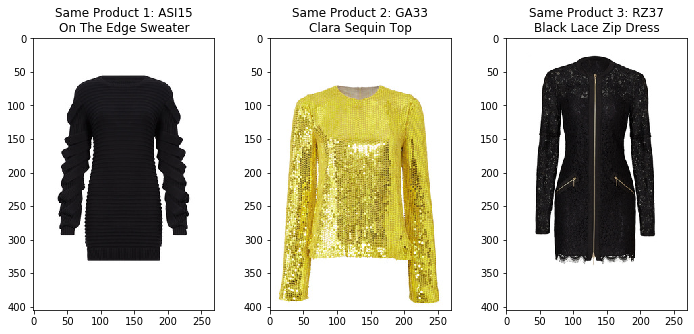


---------------------------------------------------

Products rated by similar user but not by given user:


,variable,value_6496966,value_1233836
1,Product_ECZ3,10,NaN
4,Product_HB20,10,NaN
3,Product_GEN1,8,NaN
7,Product_RZ63,8,NaN
5,Product_KP91,4,NaN



---------------------------------------------------



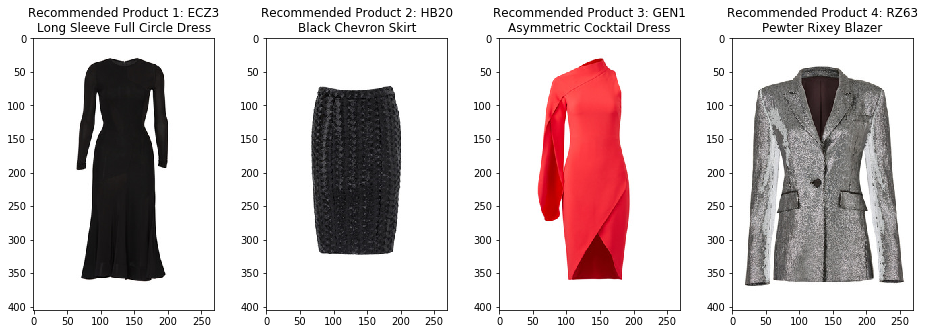

Recommended products:
Recommendation 1 https://www.renttherunway.com/shop/designers/esteban_cortazar/long_sleeve_full_circle_dress
Recommendation 2 https://www.renttherunway.com/shop/designers/hunter_bell/black_chevron_skirt
Recommendation 3 https://www.renttherunway.com/shop/designers/genny/asymmetric_cocktail_dress
Recommendation 4 https://www.renttherunway.com/shop/designers/rachel_zoe/pewter_rixey_blazer

---------------------------------------------------

Finding similar user
Iteration: 2

---------------------------------------------------

Top Similar User: 17976123
cosine: [0.14239677]

---------------------------------------------------

Similarites:


,variable,value_1233836,value_17976123
0,Product_EJ118,10.0,8.0
0,age,46.0,26.0
1,numReviewsByUser,182.0,37.0
2,heightInches,67.0,61.0
3,usStandardSize,6.0,2.0
4,weightPounds,140.0,120.0
5,bust_size,36.0,34.0
6,bust_type_C,1.0,1.0


Same product 1 https://www.renttherunway.com/shop/designers/elizabeth_and_james/black_britt_dress

---------------------------------------------------



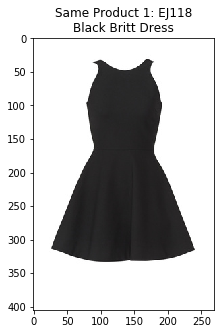


---------------------------------------------------

Products rated by similar user but not by given user:


,variable,value_17976123,value_1233836
15,Product_MH41,10,NaN
3,Product_DL258,10,NaN
4,Product_DL80,10,NaN
6,Product_EJ225,10,NaN
10,Product_JOA51,10,NaN
1,Product_CLEHNB23,10,NaN
17,Product_PLL34,10,NaN
0,Product_BLNK16,8,NaN
24,Product_VIN101,8,NaN
23,Product_SW611,8,NaN



---------------------------------------------------



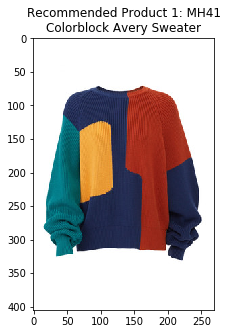

Recommended products:
Recommendation 5 https://www.renttherunway.com/shop/designers/mara_hoffman/colorblock_avery_sweater


In [0]:
#Enter User ID
user_id = 1233836 # 18286340

n_recommended = 0
n_simiar_user = 1
while(n_recommended < 5):

  print('\n---------------------------------------------------\n')
  print('Finding similar user')
  print('Iteration:', n_simiar_user)
  print('\n---------------------------------------------------\n')

  # Get top Similar user
  top_similar_user = cs_matrix[[user_id]].sort_values(ascending = False, by = user_id)
  print('Top Similar User:', top_similar_user.index[n_simiar_user])
  print('cosine:', top_similar_user.values[n_simiar_user])
  print('\n---------------------------------------------------\n')
  # Get similarities between the users
  similarities_df = get_similarities(user_id, top_similar_user.index[n_simiar_user])

  print('Similarites:')
  display(similarities_df)

  # Get product links for same products that the users bought
  same_products_img_links = same_products_links(similarities_df)
  print('\n---------------------------------------------------\n')
  print_images(same_products_img_links, 'Same Product ')
  print('\n---------------------------------------------------\n')
  
  # Get recommendations and unrated products based on the top similar user
  recos, unrated_products = get_recommendations_two_users(user_id, top_similar_user.index[n_simiar_user])

  # Subset only the required number of products
  recos = recos[:5-n_recommended]
  print('Products rated by similar user but not by given user:')
  display(unrated_products)
  print('\n---------------------------------------------------\n')

  # Get product links for recommendations
  recos = recos.apply(lambda x: x.split('_')[1]).values
  recos_df = all_product_data_list.loc[recos,['displayName', 'designer_name', 'product_img_link']]
  reco_products_img_links = recos_df.reset_index().drop(columns=['designer_name'])
  reco_products_img_links.columns = ['product',	'displayName', 'product_img_link']

  print_images(reco_products_img_links, 'Recommended Product ')
  print('Recommended products:')
  for designer, display_name in zip(recos_df['designer_name'], recos_df['displayName']):
    n_recommended+=1
    product_link = create_url(designer, display_name)
    print('Recommendation', str(n_recommended), product_link)

  # Go to the next similar user if we did not find 5 unrated prodcuts
  n_simiar_user+=1